# **Breast Tumor Segmentation using UNET Model**
## INTRODUCTION 
U-Net is a convolutional neural network (CNN) architecture primarily designed for biomedical image segmentation. It was introduced in the paper "U-Net: Convolutional Networks for Biomedical Image Segmentation" by Olaf Ronneberger et al. The architecture is known for its U-shaped structure, which consists of an encoder (contracting path) and a decoder (expanding path), allowing it to capture both spatial context and detailed localization features.



## Dataset Used
The U-Net model was trained on the Dataset_BUSI_with_GT from Kaggle, which consists of ultrasound images and corresponding segmentation masks. The dataset includes three types of images: normal, benign, and malignant. For this project, only benign and malignant images were utilized, focusing on detecting abnormalities in medical imaging.


# Essential Imports

In [2]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Data Loader

In [3]:
## defining a frame for image and mask storage
Dataset = {'img' : [],
           'mask' : []
          }

## defining data Loader function
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 256):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split(')')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i]+').png')
        maskNames.append(unames[i]+')_mask.png')
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj

In [4]:
# loading benign samples

Dataset = LoadData( Dataset, imgPath = '/kaggle/input/dataset-busi-with-gt/Dataset_BUSI_with_GT/benign'
                        , maskPath = '/kaggle/input/dataset-busi-with-gt/Dataset_BUSI_with_GT/benign'
                         , shape = 256)

In [5]:
# loading malignant samples

Dataset = LoadData( Dataset, imgPath = '/kaggle/input/dataset-busi-with-gt/Dataset_BUSI_with_GT/malignant'
                        , maskPath = '/kaggle/input/dataset-busi-with-gt/Dataset_BUSI_with_GT/malignant'
                         , shape = 256)

In [6]:
print(len(Dataset['img']))
print(Dataset['img'][0].shape)
print(Dataset['mask'][0].shape)

647
(256, 256, 3)
(256, 256)


# Train, Validation, Test Split

In [7]:
X = np.array(Dataset['img'])  
y = np.array(Dataset['mask']) 


# Step 1: Split into training and temp (val+test) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42 
)

# Step 2: Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42  
)


y_train = y_train[..., np.newaxis]
y_val = y_val[..., np.newaxis]
y_test = y_test[..., np.newaxis]

# Summary of splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")



Training set: (517, 256, 256, 3), (517, 256, 256, 1)
Validation set: (65, 256, 256, 3), (65, 256, 256, 1)
Test set: (65, 256, 256, 3), (65, 256, 256, 1)


# Displaying Data Sample

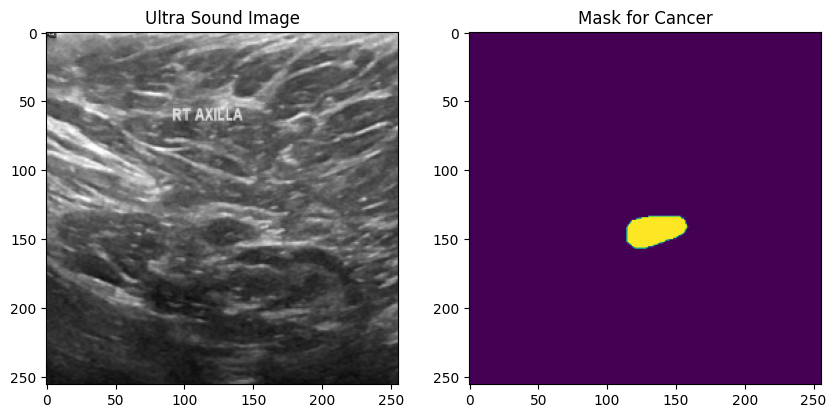

In [8]:
plt.figure(figsize = (10, 7))
plt.subplot(1,2,1)
plt.imshow(X_train[1])
plt.title('Ultra Sound Image')
plt.subplot(1,2,2)
plt.imshow(y_train[1])
plt.title('Mask for Cancer')
plt.show()

# Defining Dice Coefficient and IOU 
## Dice Coefficient
The Dice Coefficient (or Dice Similarity Coefficient, DSC) is a statistical measure used to gauge the similarity between two sets, commonly used in image segmentation tasks to compare the predicted segmentation and ground truth masks. It ranges from 0 (no overlap) to 1 (perfect overlap).

## Intersection over Union (IoU)
The Intersection over Union (IoU), also known as the Jaccard Index, measures the overlap between the predicted segmentation and the ground truth. Like the Dice coefficient, IoU ranges from 0 to 1, where 1 indicates a perfect match.

In [9]:
# function to create dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten=K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=100):
    return 1 - dice_coef(y_true, y_pred, smooth)



# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

# Model Defination
The U-Net model defined in the provided code is structured into three main parts: the encoder, bottleneck, and decoder. 
## Encoder
The encoder captures features at different resolutions using consecutive convolutional blocks, each followed by max-pooling and dropout layers to reduce dimensionality and prevent overfitting. 
## Bottleneck
The bottleneck serves as the deepest layer, capturing the most abstract features with two convolutional layers. 
## Decoder
The decoder reconstructs the segmentation map by progressively upsampling feature maps using transposed convolutions. Skip connections are incorporated to combine high-resolution features from the encoder with upsampled features in the decoder, ensuring the preservation of fine details. 

The final output layer applies a 1x1 convolution with a sigmoid activation function to produce a binary segmentation map. This modular architecture makes the model flexible and effective for image segmentation tasks.

In [11]:
###########################################################################
#                                Model   Defination                       #
###########################################################################


# this block essentially performs 2 convolution

def Conv2dBlock(inputTensor, numFilters, kernelSize, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 32, kernelSize = 3, dropouts = 0.3, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(dropouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(dropouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(dropouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(dropouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(dropouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(dropouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(dropouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(dropouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(1, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

# Model Instantiation
In this block of code the instantiation and compilation of the U-Net model is done for image segmentation tasks. 
## Input Layer
The model is instantiated with an input tensor of shape (256, 256, 3), where 256x256 represents the spatial dimensions of the input image, and 3 represents the RGB color channels.
## Model Creation
The GiveMeUnet function is used to build the U-Net model. It takes the defined input tensor and constructs the encoder, bottleneck, and decoder as described in the model definition.
## Compilation
The model is compiled with the Adam optimizer, dice_loss as the loss function, and metrics including accuracy, precision, recall, the Dice coefficient, and IoU for performance evaluation. These configurations ensure the model is optimized for accurate and robust segmentation tasks.
## Model Summary:
The print(myTransformer.summary()) command outputs a summary of the model's architecture, including details about each layer, the number of parameters, and the total number of trainable and non-trainable parameters.

In [12]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs)
myTransformer.compile(optimizer = 'Adam', loss = dice_loss, metrics = ['accuracy', 'Precision', 'Recall', dice_coef, iou_coef] )
print(myTransformer.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_1[

 Total params: 8,642,273 (32.97 MB)

 Trainable params: 8,636,385 (32.95 MB)

 Non-trainable params: 5,888 (23.00 KB)

None


# Early Stopping
The EarlyStopping callback is used to prevent overfitting during training by monitoring the validation loss (val_loss). If the validation loss does not improve for 10 consecutive epochs (defined by patience=10), the training process is halted early. The verbose=1 argument ensures that training progress is printed when early stopping is triggered. Additionally, restore_best_weights=True ensures that the model's weights are reverted to the best state (i.e., the one with the lowest validation loss) after training stops.

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=10,                  
    verbose=1,                   
    restore_best_weights=True     
)

# Training
The myTransformer model is trained using the fit() methond. It trains the model on X_train and y_train for 150 epochs, using X_val and y_val as the validation data. The callbacks [early_stopping] ensures that the early stopping mechanism is applied, which will halt training if the validation loss does not improve after a set number of epochs (based on the previously defined early_stopping callback). The verbose=1 argument provides progress updates during training. The results of the training (including the loss and metrics for each epoch) are stored in retVal.

In [16]:
retVal = myTransformer.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 150, callbacks=[early_stopping], verbose = 1)

Epoch 1/150


I0000 00:00:1733686300.537914     789 service.cc:145] XLA service 0x7f7fc4003310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733686300.538020     789 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733686338.802499     789 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - Precision: 0.1356 - Recall: 0.7073 - accuracy: 0.5254 - dice_coef: 0.2162 - iou_coef: 0.1221 - loss: 0.7848 - val_Precision: 0.0970 - val_Recall: 1.0000 - val_accuracy: 0.0945 - val_dice_coef: 0.1830 - val_iou_coef: 0.1011 - val_loss: 0.8254
Epoch 2/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 311ms/step - Precision: 0.2511 - Recall: 0.7029 - accuracy: 0.7787 - dice_coef: 0.3189 - iou_coef: 0.1909 - loss: 0.6825 - val_Precision: 0.0982 - val_Recall: 0.9999 - val_accuracy: 0.1075 - val_dice_coef: 0.1844 - val_iou_coef: 0.1019 - val_loss: 0.8234
Epoch 3/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - Precision: 0.3176 - Recall: 0.7749 - accuracy: 0.8223 - dice_coef: 0.3870 - iou_coef: 0.2419 - loss: 0.6134 - val_Precision: 0.1087 - val_Recall: 0.9880 - val_accuracy: 0.2109 - val_dice_coef: 0.1997 - val_iou_coef: 0.1113 - val_loss: 0.8082
Epoch 4/150
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - Precision: 0.3697 - Recall: 0.7726 - accuracy: 0.8545 - dice_coef: 0

# Training and Validation Results
The model performed well overall, with noticeable improvements in key evaluation metrics throughout the training process. The loss decreased significantly for both training and validation sets, indicating the model was learning and minimizing errors effectively. The accuracy showed excellent performance, reaching 98% for training and 96% for validation, suggesting the model is highly accurate at predicting outcomes.

However, precision and recall fluctuated, which could indicate some instability in how the model identified positive instances. Despite the fluctuations, the training precision reached around 90.5%, and the validation precision was 88.8%, which are strong values, though there may still be some trade-offs between precision and recall. The recall, on the other hand, was lower, especially in the validation set, with the model performing better on training recall (86.5%) compared to validation recall (64.4%). This disparity suggests the model may be overfitting to the training data, as it struggles to generalize well to unseen validation samples.

The Dice coefficient and Intersection over Union (IoU) showed continued improvement throughout the training process, with high values for both training (Dice of 88 and IoU of 78.8) and validation (Dice of 81 and IoU of 69.5), reflecting good segmentation performance.

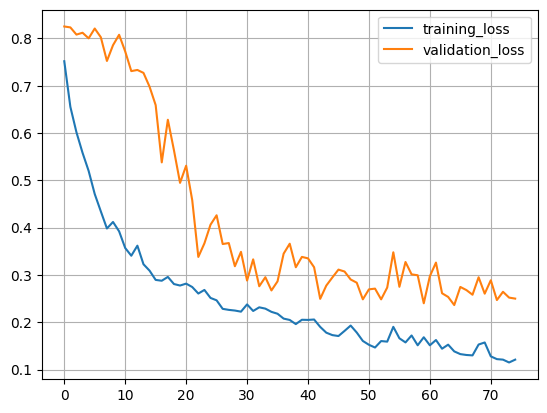

In [37]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['val_loss'], label = 'validation_loss')
plt.legend()
plt.grid(True)

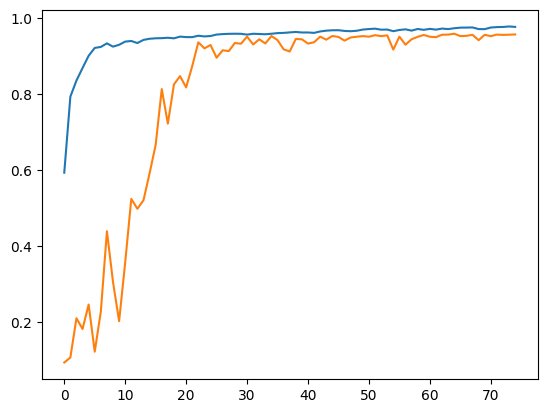

In [18]:
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.plot(retVal.history['val_accuracy'], label = 'validation_accuracy')
plt.legend()
plt.grid(True)

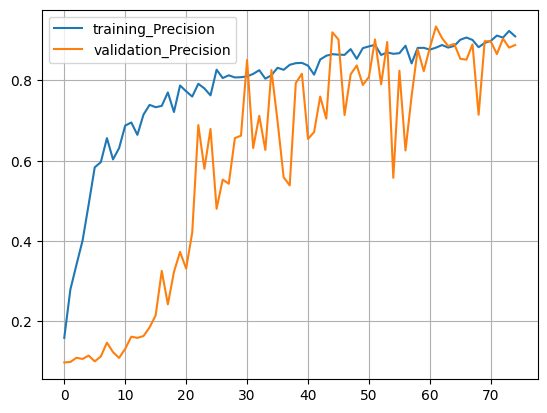

In [38]:
plt.plot(retVal.history['Precision'], label = 'training_Precision')
plt.plot(retVal.history['val_Precision'], label = 'validation_Precision')
plt.legend()
plt.grid(True)

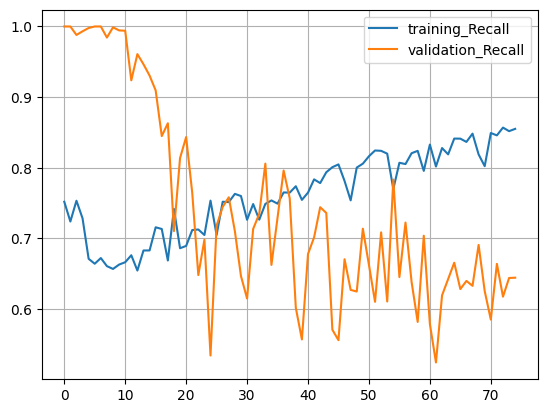

In [39]:
plt.plot(retVal.history['Recall'], label = 'training_Recall')
plt.plot(retVal.history['val_Recall'], label = 'validation_Recall')
plt.legend()
plt.grid(True)

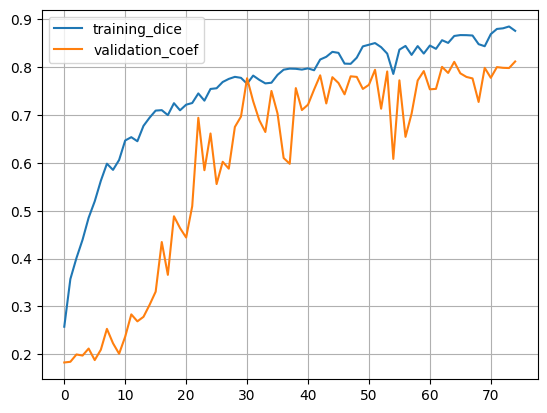

In [40]:
plt.plot(retVal.history['dice_coef'], label = 'training_dice')
plt.plot(retVal.history['val_dice_coef'], label = 'validation_coef')
plt.legend()
plt.grid(True)

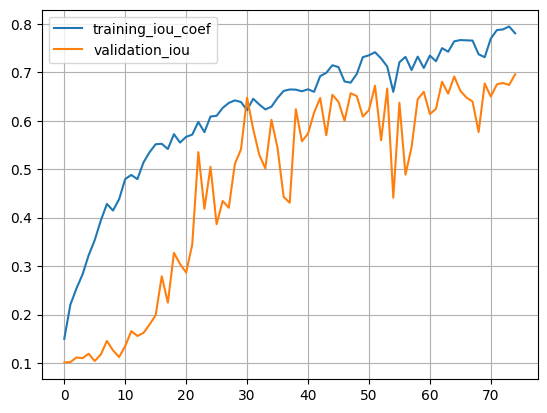

In [41]:
plt.plot(retVal.history['iou_coef'], label = 'training_iou_coef')
plt.plot(retVal.history['val_iou_coef'], label = 'validation_iou')
plt.legend()
plt.grid(True)

# Testing
The results on the testing data indicate that the model is performing well in predicting the tumors, as the predicted masks are very close to the actual masks. This suggests that the model has learned the relevant features of the tumors during training and is able to generalize effectively to unseen data. The closeness of the predicted masks to the actual masks reflects the model's strong segmentation performance, confirming that it can accurately identify tumor areas in new images.

Given the improvements in the evaluation metrics, particularly Dice coefficient and IoU, which are both indicators of good segmentation quality, it appears the model's predictions are reliable and consistent with the actual tumor boundaries. This successful prediction on the testing data is a positive indication of the model's effectiveness and its ability to be deployed in real-world scenarios for tumor detection.

In [27]:
def predict16 (x, y, model, shape = 256):
    ## getting and proccessing val data
    img = x[0:16]
    mask = y[0:16]
    #mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
  

    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(9,9))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title(' image')
    
    plt.subplot(1,3,2)
    plt.imshow(predMask)
    plt.title('Predicted mask')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('Actual mask')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


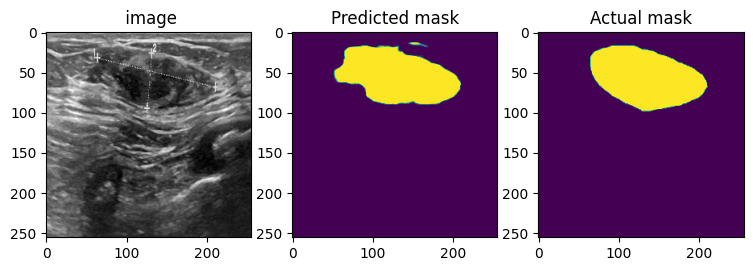

In [42]:
sixteenPrediction, actuals, masks = predict16(X_test, y_test, myTransformer)
Plotter(actuals[2], sixteenPrediction[2][:,:,0], masks[2])

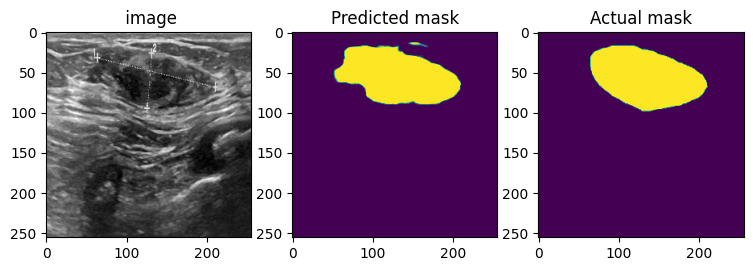

In [29]:
Plotter(actuals[3], sixteenPrediction[3][:,:,0], masks[3])

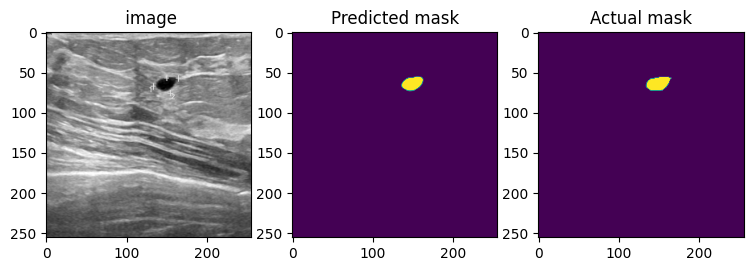

In [43]:
Plotter(actuals[4], sixteenPrediction[4][:,:,0], masks[4])

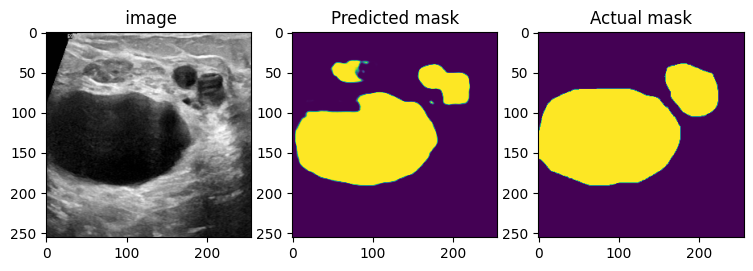

In [31]:
Plotter(actuals[5], sixteenPrediction[5][:,:,0], masks[5])

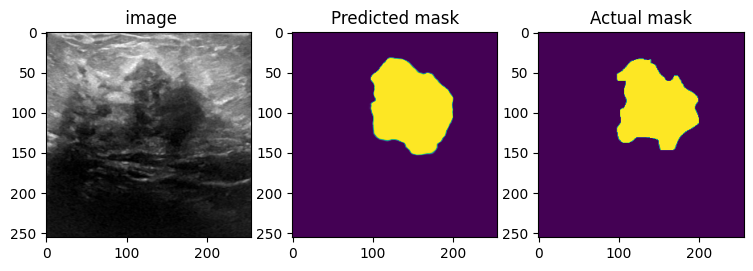

In [33]:
Plotter(actuals[7], sixteenPrediction[7][:,:,0], masks[7])

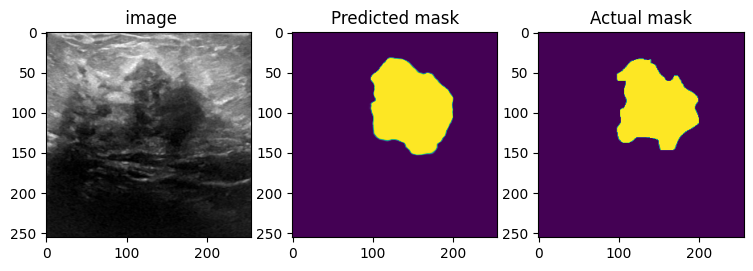

In [45]:
Plotter(actuals[8], sixteenPrediction[8][:,:,0], masks[8])

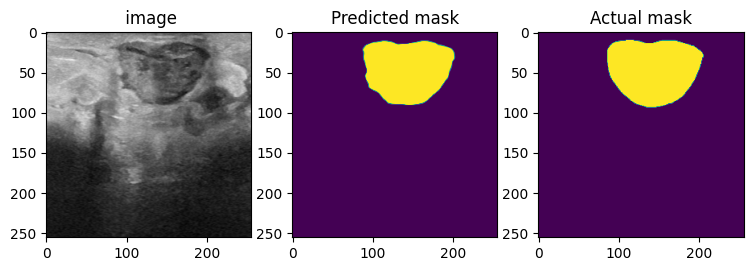

In [47]:
Plotter(actuals[9], sixteenPrediction[9][:,:,0], masks[9])

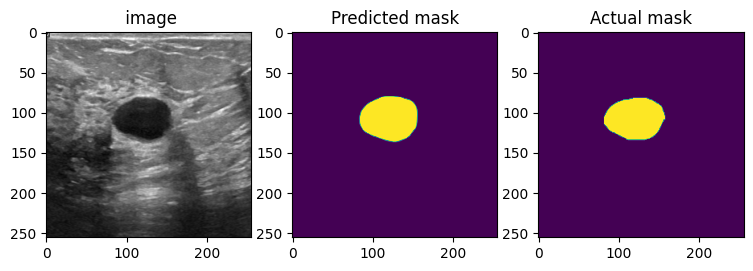

In [46]:
Plotter(actuals[10], sixteenPrediction[10][:,:,0], masks[10])

# Saving Model

In [26]:
myTransformer.save('BreastCancerSegmentor.h5')